In [64]:
from pytket import Circuit, OpType
from pytket.circuit.display import render_circuit_jupyter
from datetime import datetime
import numpy as np
import scipy
import matplotlib.pyplot as plt

## Theoretical check

$$
H\otimes H e^{it Z\otimes Z}H\otimes H = X\otimes X ?
$$

In [88]:
# obtain e^{itX\otimes X} unitary
# Define the Pauli-X matrix
import scipy.linalg


X = np.array([[0, 1],
              [1, 0]], dtype=complex)

# Compute the tensor product X ⊗ X
XX = np.kron(X, X)

# Define the parameter t
t = np.pi / 6  # You can choose any real value for t

# Compute the unitary matrix U = e^{i t X⊗X}
U1 = scipy.linalg.expm(1j * t * XX)


In [89]:
# define the tensor hadamard unitary
H = 1/np.sqrt(2) * np.array([[1,1],
                             [1,-1]], dtype=complex)
Z = np.array([[1, 0],
              [0, -1]], dtype=complex)
HH = np.kron(H, H)
ZZ = np.kron(Z, Z)
U2 = HH @ scipy.linalg.expm(1j * t * ZZ) @ HH

In [92]:
np.linalg.norm(U1-U2)

9.496780065728157e-16

## Circuit implementation

From the above test, we see that theoretically, the decomposition is correct. Now we will build the pytket circuit for this decomposition.

According to the documentation: https://docs.quantinuum.com/h-series/trainings/getting_started/pytket_quantinuum/Quantinuum_arbitrary_angle_zz.html, the arbitrary angle ZZ gate in pytket is defined as
$$
RZZ(\alpha) = e^{-i\frac{\alpha}{2}Z\otimes Z}
$$

However, it is actually
$$
RZZ(\alpha) = e^{-i\frac{\alpha\pi}{2}Z\otimes Z}
$$

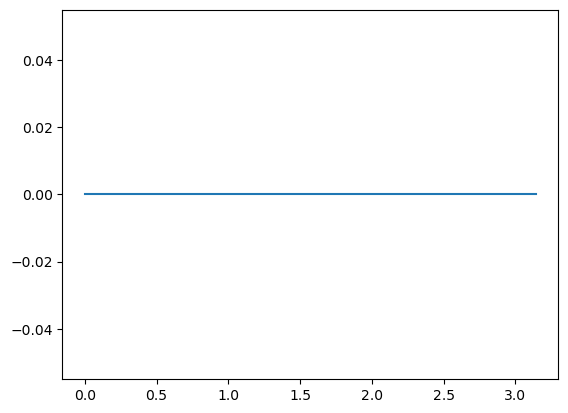

In [123]:
## RZZ in pytket
diff = []
t_range = np.linspace(0, np.pi, 10)
for t in t_range:
    ZZ_evol = scipy.linalg.expm(1j * t * ZZ)
    c = Circuit(2)
    c.ZZPhase(-t*2/np.pi, 0, 1)
    diff.append(np.linalg.norm(ZZ_evol-c.get_unitary()))
    
plt.plot(t_range, diff)
    

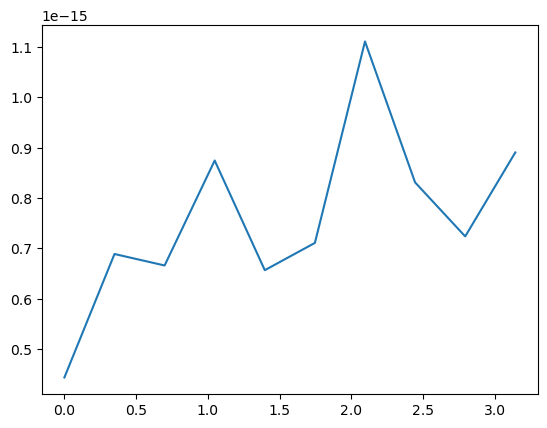

In [128]:
# compare our target circuit
diff = []
t_range = np.linspace(0, np.pi, 10)
for t in t_range:
    U1 = scipy.linalg.expm(1j * t * XX)
    circuit1 = Circuit(2)
    circuit1.H(0)
    circuit1.H(1)
    circuit1.ZZPhase(-t*2/np.pi, 0, 1)
    circuit1.H(0)
    circuit1.H(1)
    U2 = circuit1.get_unitary()
    diff.append(np.linalg.norm(U1-U2))
plt.plot(t_range, diff)

## XXZ model

Now we will use native gates to simulate the XXZ hamiltonian given by
$$
H_ = \sum _{k=0}^L \left( X_{k} X_{k + 1} + Y_{k} Y_{k + 1} + \delta Z_{k}Z_{k + 1} \right)
$$

Let's first consider the case with 2 qubit, since terms commute, the same strategy will apply to cases with more qubits.

Because the terms $X\otimes X$, $Y\otimes Y$, and $Z\otimes Z$ commute, we can write
$$
e^{it(XX+YY+ZZ)} = e^{itXX}e^{itYY}e^{itZZ}
$$

Then we have
$$
e^{itXX}=H\otimes H e^{itZZ}
$$
$$
e^{itYY}=(S\otimes S)(H\otimes H) e^{itZZ}(H\otimes H)(S^\dag\otimes S^\dag)
$$

Note that qibo.hamiltonians.XXZ for 2 qubits, there is an extra factor 2, that is QIBO_XXZ = 2 * XXZ.


In [156]:
# set up XXZ matrix
t = np.pi/6
delta = 0.5
Y = np.array([[0, -1j],
              [1j, 0]], dtype=complex)
YY = np.kron(Y, Y)
U1 = scipy.linalg.expm(1j*t*(XX+YY+delta*ZZ))

In [150]:
qc = Circuit(2)
# implement xx
qc.H(0), qc.H(1)
qc.ZZPhase(-t*2/np.pi, 0, 1)
qc.H(0), qc.H(1)

# implement yy
qc.Sdg(0), qc.Sdg(1)
qc.H(0), qc.H(1)
qc.ZZPhase(-t*2/np.pi, 0, 1)
qc.H(0), qc.H(1)
qc.S(0), qc.S(1)

# implement zz
qc.ZZPhase(-t*2/np.pi * delta, 0, 1)
U2 = qc.get_unitary()

In [133]:
render_circuit_jupyter(qc)

In [157]:
np.linalg.norm(U1-U2)

1.486673200195252e-15

## One step of DBQA

Now we have seen that using S, H, and ZZ gates, we are able to simulate the XXZ hamiltonian.

Let us first suppose for simplicity, that $D = \Delta (H)$, the diagonal restriction of $H$ and not consider the VQE circuit.